In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

from scikits.sparse.cholmod import cholesky


analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])

model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

model.glmm_par.set_free(vb_data['glmm_par_free'])
kl_hess = vb_sparse.unpack_csr_matrix(vb_data['kl_hess_packed'])

In [22]:
moment_wrapper = logit_glmm.MomentWrapper(model.glmm_par, global_only=True)
moment_jac = moment_wrapper.get_moment_jacobian(model.glmm_par.get_free())


In [13]:
sp_kl_hess = \
    model.group_model.get_sparse_kl_vec_hessian(print_every_n=500) + \
    model.global_model.get_sparse_kl_vec_hessian()
#kl_hess = np.asarray(sp_kl_hess.todense())

Group 0 of 99.


In [ ]:
#kl_hess_inv = np.linalg.inv(kl_hess)
#sp_kl_hess_inv = sp.sparse.linalg.inv(sp_kl_hess)

In [23]:
model.global_model.set_global_parameters()
global_indices = model.global_model.global_indices.get_vector()
moment_jac_global = moment_jac[:, global_indices]

def get_re_indices(g):
    vec, ind = model.group_model.set_re_parameters([g])
    return ind

get_re_indices([2])

all_re_indices = np.setdiff1d(np.arange(0, model.glmm_par.vector_size()), global_indices)

global_ix = np.ix_(global_indices, global_indices)
re_ix = np.ix_(all_re_indices, all_re_indices)
cross_ix = np.ix_(global_indices, all_re_indices)

# plt.matshow(kl_hess[np.ix_(all_re_indices, all_re_indices)]); plt.colorbar()
# plt.matshow(kl_hess[np.ix_(global_indices, all_re_indices)]); plt.colorbar()
# plt.matshow(kl_hess[np.ix_(global_indices, global_indices)]); plt.colorbar()

In [16]:
sp_kl_hess[global_ix]
sp_kl_hess_inv_term = sp.sparse.linalg.spsolve(sp_kl_hess[re_ix], sp_kl_hess[cross_ix].T)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [17]:
global_schur_inv = sp_kl_hess[global_ix] - sp_kl_hess[cross_ix] * sp_kl_hess_inv_term
global_schur = sp.sparse.linalg.inv(global_schur_inv)
global_schur = np.asarray(global_schur.todense())
#print(np.linalg.norm(global_schur - kl_hess_inv[global_ix]))

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [18]:
def get_schur_term(g):
    g_re_ind = get_re_indices([g])
    g_cross_ix = np.ix_(global_indices, g_re_ind)
    g_re_ix = np.ix_(g_re_ind, g_re_ind)
    sparse_result = sp_kl_hess[g_cross_ix] * \
                    sp.sparse.linalg.spsolve(sp_kl_hess[g_re_ix], sp_kl_hess[g_cross_ix].T)
    return np.asarray(sparse_result.todense())
    
schur_terms = []
for g in range(NG):
    if g % 500 == 0:
        print('{} of {}'.format(g + 1, NG))
    schur_terms.append(get_schur_term(g))
print('Done')


1 of 100


/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Done


2.31921148952e-10


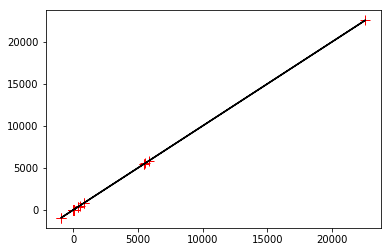

In [19]:
schur_terms = np.array(schur_terms)
kl_hess_global = np.asarray(sp_kl_hess[global_ix].todense())
global_schur_inv_terms = kl_hess_global - np.sum(schur_terms, axis=0)
global_schur_terms = np.linalg.inv(global_schur_inv_terms)
print(np.max(np.abs((global_schur_terms - global_schur))))
plt.plot(global_schur_terms.flatten(), global_schur.flatten(), 'r+', markersize=10)
plt.plot(global_schur_terms.flatten(), global_schur_terms.flatten(), 'k')

In [20]:
ev, evec = np.linalg.eig(kl_hess_global)
print(ev)

[  1.01797782e+02   3.85051409e-02   4.77927452e-05   9.09396302e-05
   9.01513830e+00   2.22941591e+01   1.95864449e+01   1.47546007e+01
   1.74962101e+01   2.76752157e-03   2.52279399e-03   2.00321751e-03
   1.26332416e-03   1.25604040e-03]


(14, 14)


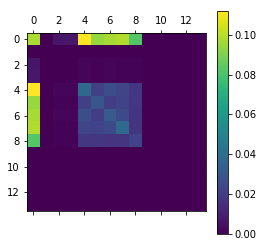

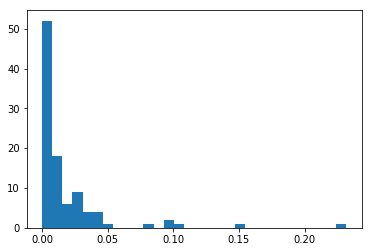

In [61]:
plt.matshow(np.std(schur_terms, axis=0)); plt.colorbar()
print(schur_terms[0].shape)
ind = 6
foo = [term[ind, ind] for term in schur_terms]
plt.figure()
plt.hist(foo, bins=30);

In [34]:
lrvb_cov_list = []
for num_g in range(1, NG + 1):
    if num_g % 500 == 0:
        print('{} of {}'.format(num_g, NG))
    global_schur_inv_terms = kl_hess_global - (NG / num_g) * np.sum(schur_terms[np.arange(0, num_g),:,:], axis=0)
    global_schur_terms = np.linalg.inv(global_schur_inv_terms)
    lrvb_cov = np.matmul(moment_jac_global, np.matmul(global_schur_terms, moment_jac_global.T))
    lrvb_cov_list.append(lrvb_cov)

In [35]:
#plt.matshow(np.sum(schur_terms, axis=0)); plt.colorbar(); plt.title('Schur sum')
#plt.matshow(np.std(schur_terms, axis=0)); plt.colorbar(); plt.title('Schur sd')
print(model.global_model.global_indices)
inds = model.global_model.global_indices['beta']['info'].get_vector()
#inds = model.global_model.global_indices['beta']['mean'].get_vector()
ix = np.ix_(inds, inds)
# plt.matshow(kl_hess_global); plt.colorbar(); plt.title('Global part')
# plt.matshow(kl_hess_global[ix]); plt.colorbar(); plt.title('Global part')


Global GLMM parameters:
	mu:
	mean: [0]
	info: [1]
	tau:
	shape: [2]
	rate: [3]
	beta:
	mean:
[4 5 6 7 8]
	info:
[ 9 10 11 12 13]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


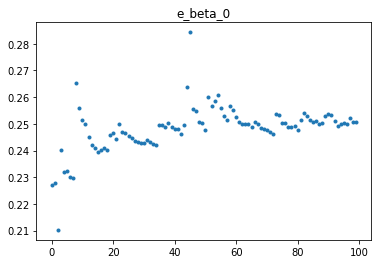

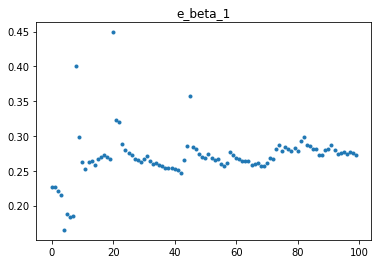

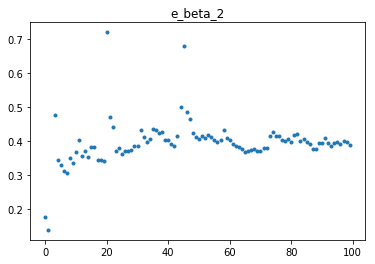

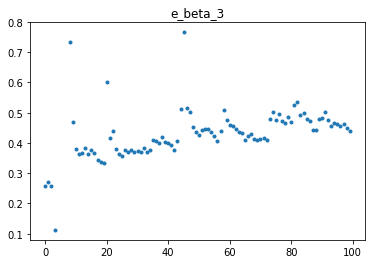

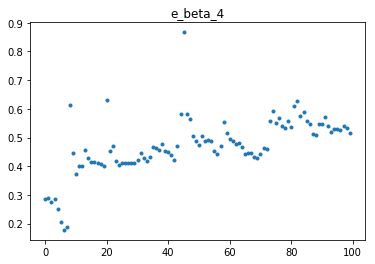

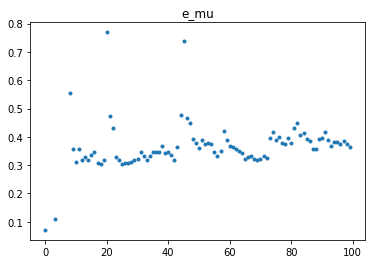

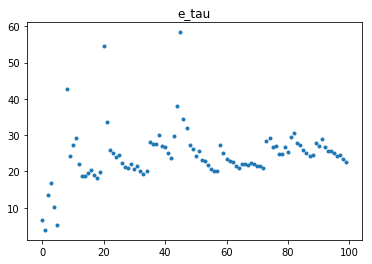

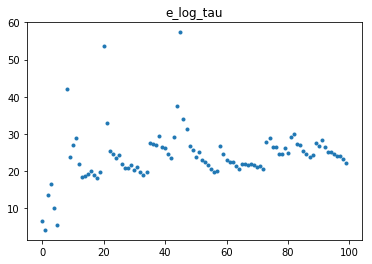

In [37]:
full_lrvb_cov = np.matmul(moment_jac_global, np.matmul(global_schur, moment_jac_global.T))

for ind in range(moment_jac_global.shape[0]):
    plt.figure()
    plt.title(moment_wrapper.moment_par.names()[ind])
    plt.plot([np.sqrt(lrvb_cov[ind, ind]) for lrvb_cov in lrvb_cov_list], '.')